In [1]:
import pandas as pd
import numpy as np
import nltk

In [2]:
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed
[nltk_data]     (_ssl.c:852)>


False

In [3]:
import re
from pprint import pprint

In [4]:
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

import spacy

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## Load data

In [5]:
#Fix SSL Error
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [7]:
df = pd.read_csv('https://query.data.world/s/uikepcpffyo2nhig52xxeevdialfl7')

In [8]:
df.columns

Index(['Unnamed: 0', 'Title', 'Year', 'Rated', 'Released', 'Runtime', 'Genre',
       'Director', 'Writer', 'Actors', 'Plot', 'Language', 'Country', 'Awards',
       'Poster', 'Ratings.Source', 'Ratings.Value', 'Metascore', 'imdbRating',
       'imdbVotes', 'imdbID', 'Type', 'tomatoMeter', 'tomatoImage',
       'tomatoRating', 'tomatoReviews', 'tomatoFresh', 'tomatoRotten',
       'tomatoConsensus', 'tomatoUserMeter', 'tomatoUserRating',
       'tomatoUserReviews', 'tomatoURL', 'DVD', 'BoxOffice', 'Production',
       'Website', 'Response'],
      dtype='object')

In [9]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [10]:
features_index = [0, 5, 7, 8, 9, 34]
df = df.iloc[:, features_index]

In [11]:
df['index'] = pd.Series(df.index)
df

,Title,Genre,Writer,Actors,Plot,Production,index
0,The Shawshank Redemption,"Crime, Drama","Stephen King (short story ""Rita Hayworth and S...","Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Two imprisoned men bond over a number of years...,Columbia Pictures,0
1,The Godfather,"Crime, Drama","Mario Puzo (screenplay), Francis Ford Coppola ...","Marlon Brando, Al Pacino, James Caan, Richard ...",The aging patriarch of an organized crime dyna...,Paramount Pictures,1
2,The Godfather: Part II,"Crime, Drama","Francis Ford Coppola (screenplay), Mario Puzo ...","Al Pacino, Robert Duvall, Diane Keaton, Robert...",The early life and career of Vito Corleone in ...,Paramount Pictures,2
3,The Dark Knight,"Action, Crime, Drama","Jonathan Nolan (screenplay), Christopher Nolan...","Christian Bale, Heath Ledger, Aaron Eckhart, M...",When the menace known as the Joker emerges fro...,Warner Bros. Pictures/Legendary,3
4,12 Angry Men,"Crime, Drama","Reginald Rose (story), Reginald Rose (screenplay)","Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",A jury holdout attempts to prevent a miscarria...,Criterion Collection,4
...,...,...,...,...,...,...,...
245,The Lost Weekend,"Drama, Film-Noir","Charles R. Jackson (from the novel by), Charle...","Ray Milland, Jane Wyman, Phillip Terry, Howard...",The desperate life of a chronic alcoholic is f...,Paramount Pictures,245
246,Short Term 12,Drama,Destin Daniel Cretton,"Brie Larson, John Gallagher Jr., Stephanie Bea...",A 20-something supervising staff member of a r...,Cinedigm,246
247,His Girl Friday,"Comedy, Drama, Romance","Charles Lederer (screen play), Ben Hecht (from...","Cary Grant, Rosalind Russell, Ralph Bellamy, G...",A newspaper editor uses every trick in the boo...,Columbia Pictures,247
248,The Straight Story,"Biography, Drama","John Roach, Mary Sweeney","Sissy Spacek, Jane Galloway Heitz, Joseph A. C...",An old man makes a long journey by lawn-mover ...,Buena Vista Pictures,248


## Cleaning Data

In [12]:
data = df.Plot.values.tolist()
data

['Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
 'The aging patriarch of an organized crime dynasty transfers control of his clandestine empire to his reluctant son.',
 'The early life and career of Vito Corleone in 1920s New York is portrayed while his son, Michael, expands and tightens his grip on the family crime syndicate.',
 'When the menace known as the Joker emerges from his mysterious past, he wreaks havoc and chaos on the people of Gotham, the Dark Knight must accept one of the greatest psychological and physical tests of his ability to fight injustice.',
 'A jury holdout attempts to prevent a miscarriage of justice by forcing his colleagues to reconsider the evidence.',
 'In German-occupied Poland during World War II, Oskar Schindler gradually becomes concerned for his Jewish workforce after witnessing their persecution by the Nazi Germans.',
 "Gandalf and Aragorn lead the World of Men against Sauron's

In [13]:
from nltk.corpus import stopwords

In [14]:
stopwords = stopwords.words('english')

In [15]:
stopwords.extend(['from', 'subject', 're', 'edu', 'use'])

In [16]:
# Convert sentences to words spare

def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(sentence, deacc=True))

In [17]:
data_words = list(sent_to_words(data))
data_words

[['two',
  'imprisoned',
  'men',
  'bond',
  'over',
  'number',
  'of',
  'years',
  'finding',
  'solace',
  'and',
  'eventual',
  'redemption',
  'through',
  'acts',
  'of',
  'common',
  'decency'],
 ['the',
  'aging',
  'patriarch',
  'of',
  'an',
  'organized',
  'crime',
  'dynasty',
  'transfers',
  'control',
  'of',
  'his',
  'clandestine',
  'empire',
  'to',
  'his',
  'reluctant',
  'son'],
 ['the',
  'early',
  'life',
  'and',
  'career',
  'of',
  'vito',
  'corleone',
  'in',
  'new',
  'york',
  'is',
  'portrayed',
  'while',
  'his',
  'son',
  'michael',
  'expands',
  'and',
  'tightens',
  'his',
  'grip',
  'on',
  'the',
  'family',
  'crime',
  'syndicate'],
 ['when',
  'the',
  'menace',
  'known',
  'as',
  'the',
  'joker',
  'emerges',
  'from',
  'his',
  'mysterious',
  'past',
  'he',
  'wreaks',
  'havoc',
  'and',
  'chaos',
  'on',
  'the',
  'people',
  'of',
  'gotham',
  'the',
  'dark',
  'knight',
  'must',
  'accept',
  'one',
  'of',
  't

## Create bigram and trigram models

In [43]:
bigram = gensim.models.Phrases(data_words, min_count=2, threshold=10)

In [44]:
trigram = gensim.models.Phrases(bigram[data_words], threshold=10)

In [45]:
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [46]:
# trigram_mod[bigram_mod[data_words[5]]]

In [47]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]

In [62]:
def make_bigram(texts):
#     [print(bigram_mod[doc]) for doc in texts]
    return [bigram_mod[doc] for doc in texts]

In [63]:
def make_trigram(texts):
#     [print(trigram_mod[bigram_mod[doc]]) for doc in texts]
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [89]:
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(texts, allowed_postags=['ADV', 'NOUN', 'ADJ', 'VERB']):
    texts_out = []
    for sent in texts:
#         print(sent)
        doc = nlp(' '.join(sent))
#         [print(token.pos_) for token in doc]
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        
    return texts_out

In [84]:
# Remove stopwords

data_words_nostops = remove_stopwords(data_words)

In [85]:
# Make bigram

data_word_bigrams = make_bigram(data_words_nostops)

In [86]:
# Make trigram

# data_word_trigrams = make_trigram(data_word_bigrams[data_words_nostops])

In [87]:
#before download spacy en model
# python3 -m spacy download en

In [90]:
data_lemmatized = lemmatization(data_word_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [91]:
data_lemmatized

[['imprison',
  'man',
  'bond',
  'number',
  'year',
  'find',
  'eventual',
  'redemption',
  'act',
  'common',
  'decency'],
 ['age',
  'patriarch',
  'organize',
  'crime',
  'dynasty',
  'transfer',
  'control',
  'son'],
 ['early',
  'life',
  'career',
  'corleone',
  'portray',
  'son',
  'expand',
  'family',
  'crime',
  'syndicate'],
 ['know',
  'emerge',
  'mysterious',
  'people',
  'must',
  'accept',
  'great',
  'psychological',
  'physical',
  'test',
  'ability',
  'fight',
  'injustice'],
 ['jury', 'attempt', 'force', 'colleague', 'reconsider', 'evidence'],
 ['occupy',
  'gradually',
  'become',
  'concerned',
  'jewish',
  'workforce',
  'witness',
  'persecution',
  'nazi'],
 ['aragorn', 'lead', 'world', 'man', 'draw', 'ring'],
 ['live',
  'mob',
  'hit',
  'man',
  'bandit',
  'intertwine',
  'violence',
  'redemption'],
 ['office',
  'worker',
  'look',
  'way',
  'change',
  'life',
  'crosse',
  'path',
  'devil',
  'may',
  'care',
  'soap',
  'maker',
  'fo

## Create dictionary and corpus for model

In [159]:
id2word = corpora.Dictionary(data_lemmatized)

In [100]:
texts = data_lemmatized

In [161]:
corpus = [id2word.doc2bow(doc) for doc in texts]

## Building LDA model

In [146]:
lda_model = gensim.models.LdaModel(corpus=corpus,
                                   id2word=id2word,
                                   num_topics=18,
                                   random_state=42,
                                   update_every=1,
                                   alpha='auto', 
                                   per_word_topics=True)

In [155]:
lda_model.save('best_ldamodel')

In [156]:
lda_model = gensim.models.LdaModel.load('best_ldamodel')

In [157]:
# pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [148]:
pprint(lda_model.print_topics())

[(0,
  '0.011*"get" + 0.010*"criminal" + 0.010*"dead" + 0.010*"war" + 0.010*"close" '
  '+ 0.010*"help" + 0.010*"assume" + 0.010*"lead" + 0.006*"must" + '
  '0.006*"child"'),
 (1,
  '0.010*"mysterious" + 0.010*"powerful" + 0.010*"drug" + 0.010*"dead" + '
  '0.010*"husband" + 0.010*"death" + 0.010*"destroy" + 0.010*"torment" + '
  '0.010*"reality" + 0.010*"rebel"'),
 (2,
  '0.020*"young" + 0.016*"become" + 0.013*"man" + 0.012*"fight" + '
  '0.012*"woman" + 0.008*"boxing" + 0.008*"actually" + 0.008*"together" + '
  '0.008*"dragon" + 0.008*"steal"'),
 (3,
  '0.011*"surprise" + 0.011*"attempt" + 0.011*"british" + 0.011*"search" + '
  '0.011*"must" + 0.009*"american" + 0.006*"family" + 0.006*"man" + '
  '0.006*"able" + 0.006*"boundary"'),
 (4,
  '0.014*"man" + 0.010*"good" + 0.010*"know" + 0.010*"soldier" + 0.010*"line" '
  '+ 0.010*"help" + 0.010*"friend" + 0.010*"fall" + 0.009*"go" + '
  '0.009*"family"'),
 (5,
  '0.015*"lose" + 0.010*"home" + 0.010*"occupy" + 0.010*"rescue" + '
  '0.010*

In [149]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))


Perplexity:  -8.084625889876627


In [151]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5616072975833031


In [152]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/datnguyen/Documents/Git/env/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
13     0.171377  0.005543       1        1  8.520844
6     -0.052119  0.115711       2        1  7.378985
12    -0.070613 -0.109375       3        1  6.873839
14    -0.109535  0.101420       4        1  6.825365
2      0.053377  0.051400       5        1  6.641479
11    -0.035779 -0.065949       6        1  5.847510
15     0.013111  0.003699       7        1  5.688096
9     -0.056833 -0.010963       8        1  5.609198
10     0.072499  0.081051       9        1  5.400521
4     -0.018445 -0.002590      10        1  5.331923
16     0.084633 -0.027854      11        1  5.027813
5      0.034392  0.016143      12        1  5.017334
1     -0.007102 -0.066607      13        1  5.002484
0     -0.028669 -0.038018      14        1  4.827814
3     -0.014390  0.022027      15        1  4.497085
8      0.034517 -0.070753      16        1  4.078154
7     -0.027728 -0.029554      17        1  3.775658
17    -0.042695  0.024668      18        1  3.655906, topic_info=    Category       Freq     Term      Total  loglift  logprob
183  Default  15.000000    young  15.000000  30.0000  30.0000
7    Default  16.000000      man  16.000000  29.0000  29.0000
63   Default   6.000000     live   6.000000  28.0000  28.0000
438  Default   5.000000      old   5.000000  27.0000  27.0000
104  Default  12.000000   friend  12.000000  26.0000  26.0000
..       ...        ...      ...        ...      ...      ...
261  Topic18   0.583830   mother   2.541881   1.8378  -5.0972
748  Topic18   0.583830  however   1.867521   2.1461  -5.0972
201  Topic18   0.583819     take   8.573067   0.6220  -5.0972
343  Topic18   0.583816     wife   7.851137   0.7100  -5.0972
559  Topic18   0.583815      day   4.442557   1.2794  -5.0972

[945 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
505       1  0.589394  abandon
505       6  0.294697  abandon
505      16  0.294697  abandon
27        5  0.755838  ability
215      10  0.518816     able
...     ...       ...      ...
183       7  0.063638    young
183       8  0.127277    young
183      11  0.063638    young
183      12  0.063638    young
183      18  0.127277    young

[1399 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 7, 13, 15, 3, 12, 16, 10, 11, 5, 17, 6, 2, 1, 4, 9, 8, 18])

## Finding optimal topic values for LDA model

In [142]:
def compute_coherence_values(texts=data_lemmatized, id2word=id2word, corpus=corpus, limit_topics=40):
    list_models = []
    coherence_values = []
    max_coherence = 0
    max_topic_coherence = 5
    
    for i in range(5, limit_topics):
        lda_model = gensim.models.LdaModel(corpus=corpus, 
                                           id2word=id2word, 
                                           num_topics=i,
                                           random_state=42,
                                           update_every=1, 
                                           alpha='auto',
                                           per_word_topics=True)
        coherence_model_lda = CoherenceModel(model=lda_model, 
                                             texts=texts, 
                                             dictionary=id2word, 
                                             coherence='c_v')
        coherence_model_lda_value = coherence_model_lda.get_coherence()
        if max_coherence < coherence_model_lda_value:
            max_coherence = coherence_model_lda_value
            max_topic_coherence = i
        
        list_models.append(lda_model)
        coherence_values.append(coherence_model_lda_value)
    
    return list_models, coherence_values, max_topic_coherence, max_coherence
        

In [143]:
model_list, coherence_values, max_topic_coherence, max_coherence = compute_coherence_values(id2word=id2word, corpus=corpus, texts=data_lemmatized, limit_topics=40)

In [144]:
print(max_topic_coherence, max_coherence)

18 0.5616072975833031


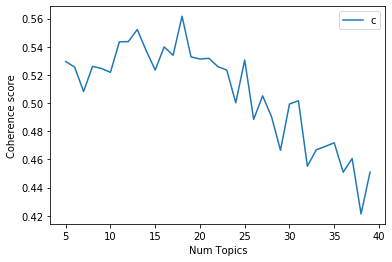

In [145]:
limit=40; start=5; step=6;
x = range(start, limit)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

## Prediction

In [162]:
unseen_topic = corpus[0]

In [163]:
lda_model[unseen_topic]

([(7, 0.92861617)],
 [(0, [7]),
  (1, [7]),
  (2, [7]),
  (3, [7]),
  (4, [7]),
  (5, [7]),
  (6, [7]),
  (7, [7]),
  (8, [7]),
  (9, [7]),
  (10, [7])],
 [(0, [(7, 0.9999651)]),
  (1, [(7, 0.9999651)]),
  (2, [(7, 0.9999651)]),
  (3, [(7, 0.999965)]),
  (4, [(7, 0.9999651)]),
  (5, [(7, 0.99998266)]),
  (6, [(7, 0.9999652)]),
  (7, [(7, 0.999994)]),
  (8, [(7, 0.9999651)]),
  (9, [(7, 0.99998647)]),
  (10, [(7, 0.99998647)])])